# Chapter 8: Random walks and the structure of Macromolecules


(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
# Our numerical workhorses
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
import mpmath

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D # For 3D plots

# Seaborn, useful for graphics
import seaborn as sns

# Import the default plotting style
import plotting_style as pstyle
# Set plotting style
pstyle.set_plotting_style()

# Function to import and display images from the Garland website
from IPython.display import Image

# Magic function to make matplotlib inline
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# Define directories
figdir = '../fig/'

## 8.4 Binomial and Gaussian distributions

Investigate by plotting how as the number of segments $N$ of a polymer chain is increased, the binomial end-to-end distribution becomes a Gaussian distribution. Compare the different distributions in a way analogous to Figure 8.4. Also, investigate the fractional error made by approximating the binomial distribution with the Gaussian. What conclusions do you draw?

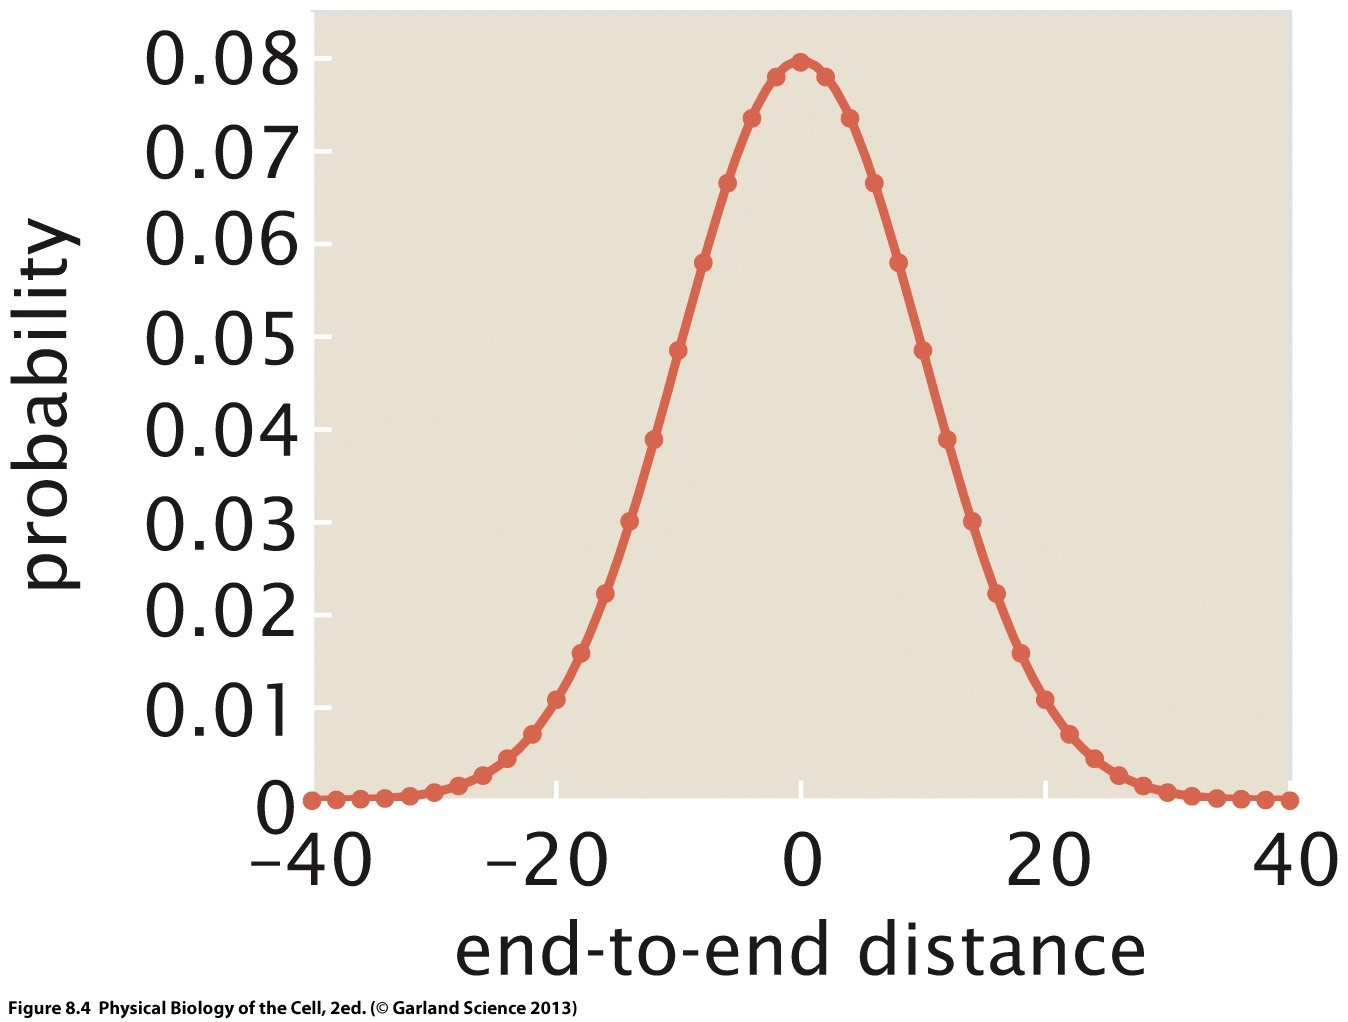

In [2]:
Image(url='http://microsite.garlandscience.com/pboc2/resources/jpegs/figures' +
      '/ch08/ch08/figure_08_04.jpg',
     embed=True, width=500, height=500)

### Solution

For a 1D polymer performing a random walk with $N$ segments the distribution of steps to the right $n_r \sim \text{Bin}(1/2, N)$. If instead we compute the distribution of the end-to-end distance $R$ this is of the form
$$
P(R \mid N) = {N! \over ({N \over 2} + {R \over 2a})! + ({N \over 2} - {R \over 2a})}
\left( {1 \over 2} \right)^N,
$$
where $a$ is the length of a single Kuhn segment. This distribution has mean zero and variance $Na^2$. This function can be simply evaluated as a Binomial distribution for even $R$ values where $n_r = (N + R / a) / 2$


In the $\lim N \rightarrow \infty$ this can be approximated as a Gaussian distribution of the form
$$
P(R \mid N) \approx {1 \over \sqrt{2\pi Na^2}} e^{- {R^2 \over 2Na^2}}.
$$

Since the Gaussian approximation is a continuous distribution it cannot be directly compared with the discrete case. To be directly comparable the probability of having an end-to-end distance $R$ where $R \in \mathbb{N}$ we need to perform an integral over the PDF. For example let's say that we want the probability of falling in $R = 8$, since $R$ can only take even number values then this will be computed as
$$
P(R = 8 \mid N) \approx \int_7^9 dR
                        {1 \over \sqrt{2\pi Na^2}} e^{- {R^2 \over 2Na^2}}
$$

This can be easily computed by taking the difference in the cumulative distribution functions (CDF) like
$$
P(R = 8 \mid N) \approx CDF(R = 7 \mid N) - CDF(R = 9 \mid N),
$$
where
$$
CDF(R = x \mid N) \equiv \int_{-\infty}^x dR
                        {1 \over \sqrt{2\pi Na^2}} e^{- {R^2 \over 2Na^2}}.
$$
Such function is already implemented in `scipy`.

In [3]:
def polymer_discrete(R, N, a=1):
    '''
    Computes the PMF evaluated at point Rfor a 1D polymer with N segments 
    of length a.
    
    Parameters
    ----------
    R : array-like.
        en-to-end distance.
    N : int.
        Number of Kuhn segments in polymer
    a : float.
        Length of each Kuhn segment
    '''
    return sp.stats.binom.pmf(((N + R / a) / 2).astype(int), N, 1 / 2)
    
def polymer_continuous(R, N, a=1):
    '''
    Computes the Gaussian PDF evaluated at point R for a 1D polymer with 
    N segments of length a.
    
    Parameters
    ----------
    R : array-like.
        en-to-end distance.
    N : int.
        Number of Kuhn segments in polymer
    a : float.
        Length of each Kuhn segment
    '''
    cdf_top = sp.stats.norm.cdf(R + 1, loc=0, scale=np.sqrt(N * a**2))
    cdf_bottom = sp.stats.norm.cdf(R - 1, loc=0, scale=np.sqrt(N * a**2))
    return cdf_top - cdf_bottom

Having coded this let's now compare the distribution for different values of $N$.

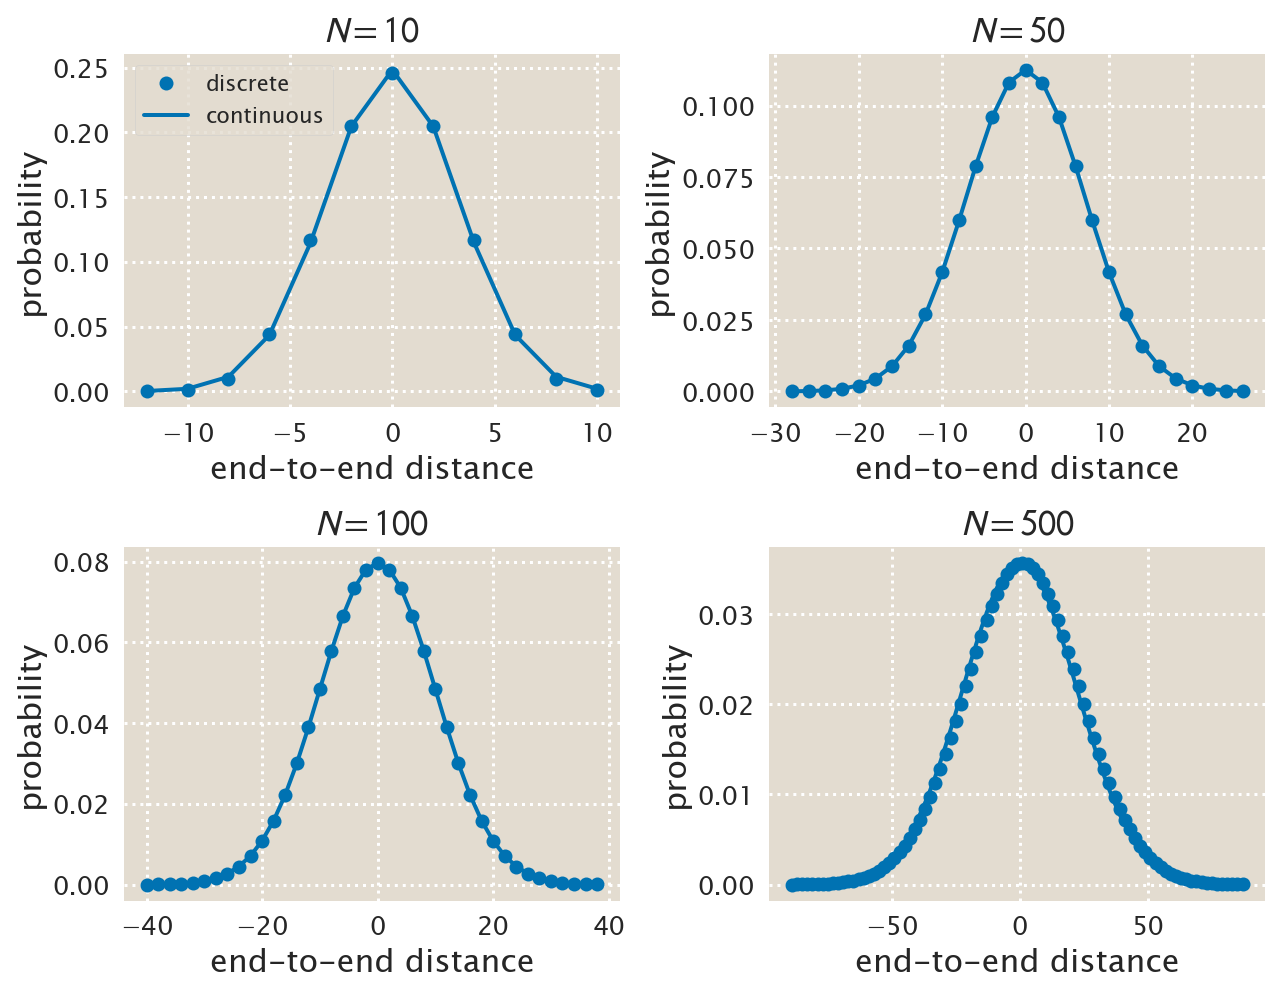

In [4]:
# Define values of N to be evaluated
N_array = [10, 50, 100, 500]

# Define the value of a
a = 1 # a.u.

# Define color for plot
color = sns.color_palette('colorblind', n_colors=1)[0]

# Initialize figure with 4 panels
fig, ax = plt.subplots(2, 2, figsize=(9, 7))
ax = ax.ravel() # Flatten the ax array to be 1D rather than 2D

# Loop through each N evaluating the distributions
for i, N in enumerate(N_array):
    # Select the range to evaluate the functions
    R = np.arange(int(-4 * np.sqrt(N * a**2)), 
                      int(4 * np.sqrt(N * a**2)), 2).astype(int)
    
    # Evaluate discrete dist
    PMF = polymer_discrete(R, N, a)
    # Evaluate continuous dist
    PDF = polymer_continuous(R, N, a)
    
    # Plot distributions on top of each other
    ax[i].plot(R, PMF, marker='o', lw=0, label='discrete', color=color)
    ax[i].plot(R, PDF, label='continuous', color=color)
    
    # Label plot
    ax[i].set_xlabel('end-to-end distance')
    ax[i].set_ylabel(r'probability')
    ax[i].set_title(r'$N = {:d}$'.format(N))
    

ax[0].legend()
plt.tight_layout()
plt.savefig(figdir + 'problem_08_04_01.png', bbox_inches='tight')

To investigate the error we will compute the following quantity for different values of $N$
$$
\text{cumulative error} = \sqrt{\sum_R \left( P_d(R \mid N) -
                                       P_c(R \mid N) \right)^2}
$$ 
where $P_d$ is the discrete probability and $P_c$ the continuous.

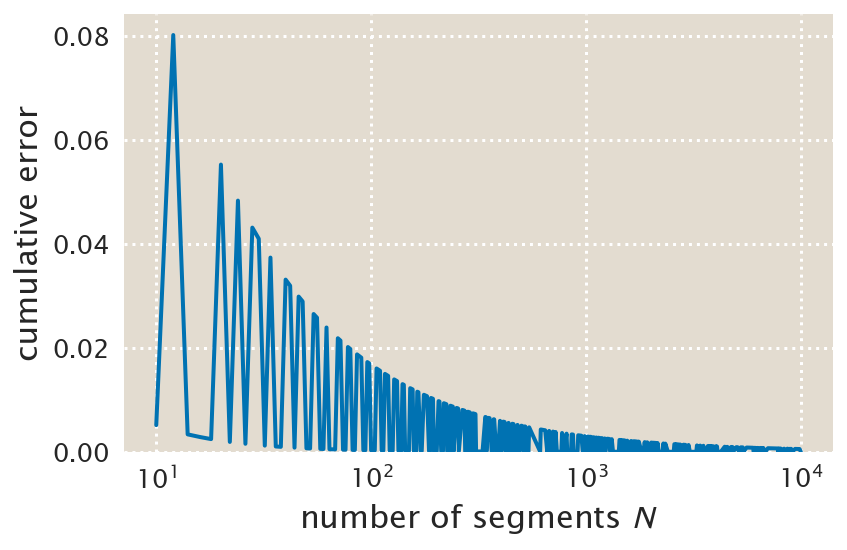

In [5]:
# Define array for N
N_array = np.unique(np.logspace(1, 4, 1000).astype(int))
N_array = [x for x in N_array if x%2 == 0]

# Initialize array to save differences
frac_error = np.zeros(len(N_array))

# Loop through each value of N
for i, N in enumerate(N_array):
    # Select the range to evaluate the functions
    R = np.arange(int(-4 * np.sqrt(N * a**2)), 
                      int(4 * np.sqrt(N * a**2)), 2).astype(int)
    
    # Evaluate discrete dist
    PMF = polymer_discrete(R, N, a)
    # Evaluate continuous dist
    PDF = polymer_continuous(R, N, a)
    
    # Evaluate and save difference
    frac_error[i] = np.sqrt(np.sum((PMF - PDF)**2))

# Plot fractional error
plt.plot(N_array, frac_error)

plt.xlabel('number of segments $N$')
plt.ylabel('cumulative error')
plt.ylim(bottom=0)
plt.xscale('log')

plt.tight_layout()
plt.savefig(figdir + 'problem_08_04_02.png', bbox_inches='tight')

There is a weird almost periodic behavior with this error that I can't explain. I would have to dig into this much more to figure it out.

Another way to study the error is the fractional error at each of the values. We define this as
$$
\text{fractional error}(R \mid N) \equiv {P_c(R \mid N) - P_d(R \mid N) \over
                                          P_d(R \mid N)},
$$
i.e. how big is the deviation at each value of $R$ for different $N$. Let's look at this quantity

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


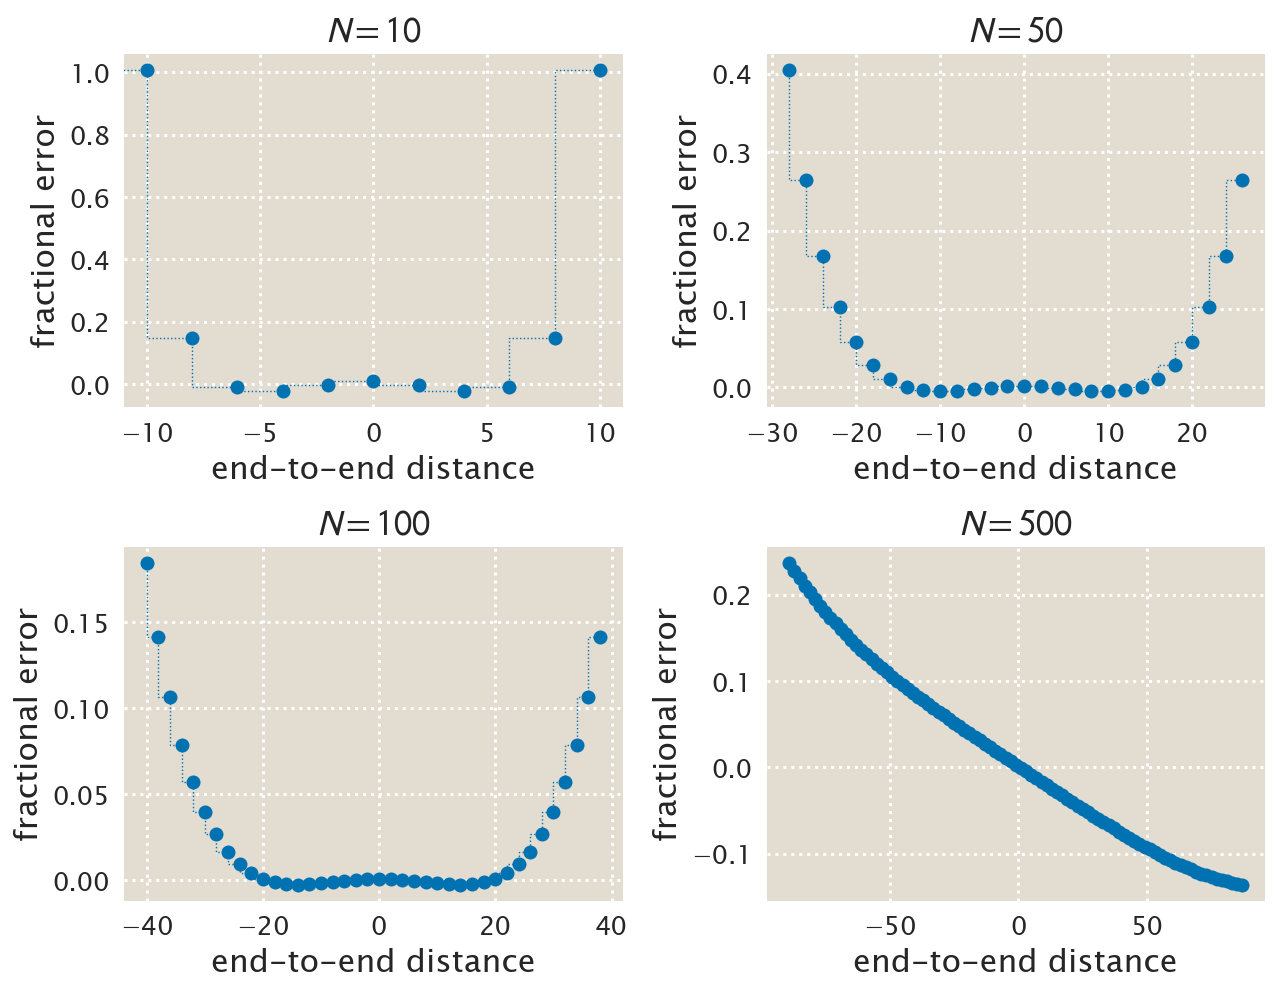

In [6]:
# Define values of N to be evaluated
N_array = [10, 50, 100, 500]

# Define the value of a
a = 1 # a.u.

# Initialize figure with 4 panels
fig, ax = plt.subplots(2, 2, figsize=(9, 7))
ax = ax.ravel() # Flatten the ax array to be 1D rather than 2D

# Loop through each N evaluating the distributions
for i, N in enumerate(N_array):
    # Select the range to evaluate the functions
    R = np.arange(int(-4 * np.sqrt(N * a**2)), 
                      int(4 * np.sqrt(N * a**2)), 2).astype(int)
    
    # Evaluate discrete dist
    PMF = polymer_discrete(R, N, a)
    # Evaluate continuous dist
    PDF = polymer_continuous(R, N, a)
    
    # Plot distributions on top of each other
    ax[i].plot(R, (PDF - PMF) / PMF, marker='o',
               lw=0.7, drawstyle='steps', linestyle=':')
    
    # Label plot
    ax[i].set_xlabel('end-to-end distance')
    ax[i].set_ylabel(r'fractional error')
    ax[i].set_title(r'$N = {:d}$'.format(N))
    

plt.tight_layout()
plt.savefig(figdir + 'problem_08_04_03.png', bbox_inches='tight')

Interestingly the fractional error increases the further we move from the tails. This is most likely because at the tails the probability is very close to zero so the number explodes. But if we compute not the fractional but the absolute error this effect should disappear.

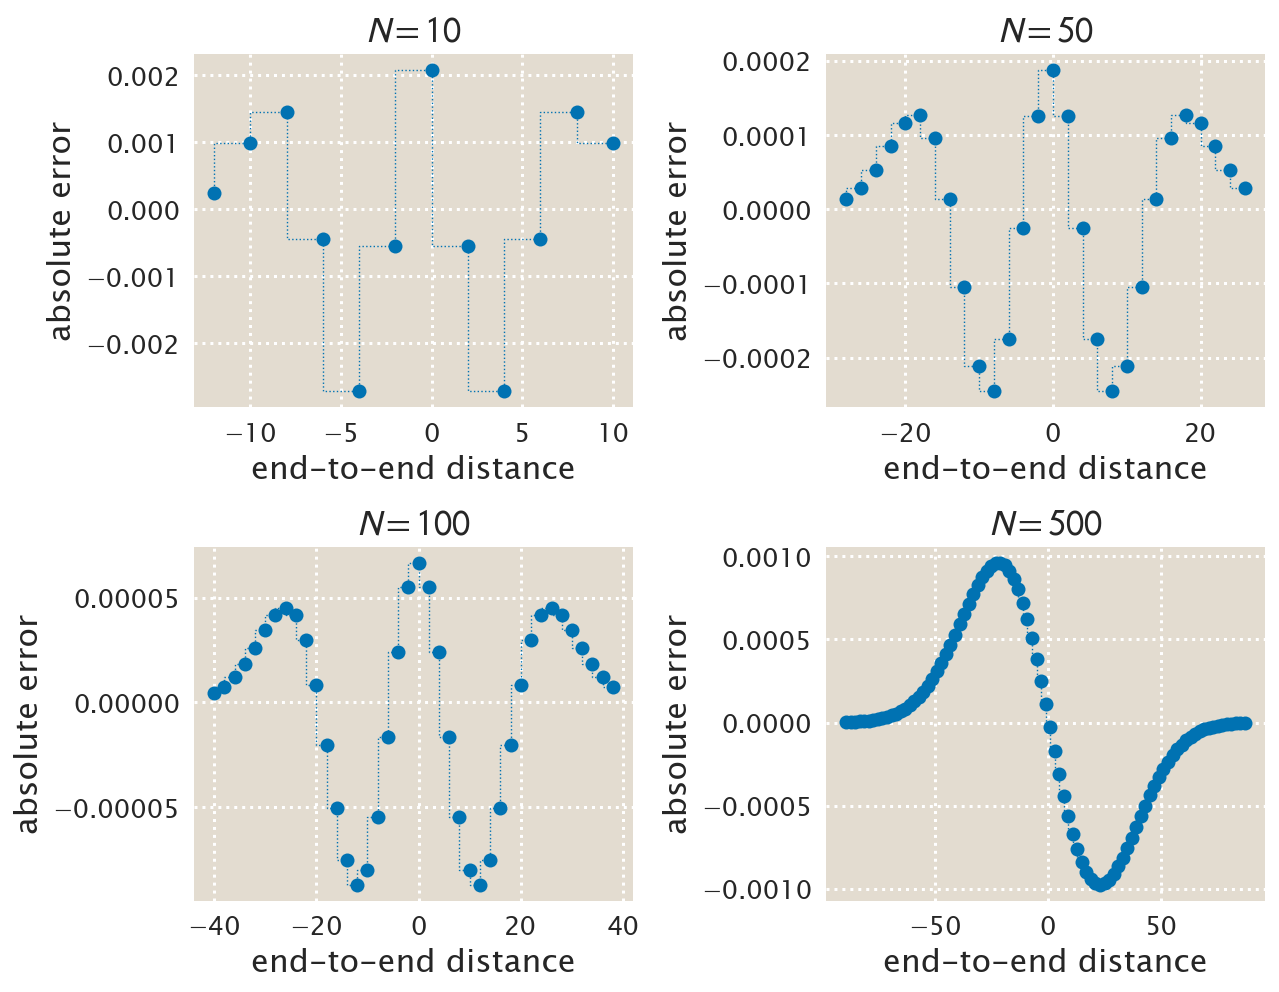

In [7]:
# Define values of N to be evaluated
N_array = [10, 50, 100, 500]

# Define the value of a
a = 1 # a.u.

# Initialize figure with 4 panels
fig, ax = plt.subplots(2, 2, figsize=(9, 7))
ax = ax.ravel() # Flatten the ax array to be 1D rather than 2D

# Loop through each N evaluating the distributions
for i, N in enumerate(N_array):
    # Select the range to evaluate the functions
    R = np.arange(int(-4 * np.sqrt(N * a**2)), 
                      int(4 * np.sqrt(N * a**2)), 2).astype(int)
    
    # Evaluate discrete dist
    PMF = polymer_discrete(R, N, a)
    # Evaluate continuous dist
    PDF = polymer_continuous(R, N, a)
    
    # Plot distributions on top of each other
    ax[i].plot(R, (PDF - PMF), marker='o',
               lw=0.7, drawstyle='steps', linestyle=':')
    
    # Label plot
    ax[i].set_xlabel('end-to-end distance')
    ax[i].set_ylabel(r'absolute error')
    ax[i].set_title(r'$N = {:d}$'.format(N))
    

plt.tight_layout()
plt.savefig(figdir + 'problem_08_04_04.png', bbox_inches='tight')

There we see that indeed the absolute value is not greater at the tails.

## 8.8 Three-dimensional random walk and polymer cyclization

Calculate the cyclization probability of a discrete random walk in one, two, and three dimensions.

### Solution

As we solve this problem for the 2D random walk we come to a point where we have to integrate a function of the form
$$
\Omega_o = \left( 1 \over 2 \pi \right)^2 \cdot 2^N
\int_{- \infty}^{\infty} d k_x \int_{- \infty}^{\infty} d k_y
\left( cos(k_x) + cos(k_y) \right)^N.
$$

Since the integral doesn't have a closed form solution let's gain some intuition for an approximation by plotting the function
$$
f(k_x, k_y, N) = \left( cos(k_x) + cos(k_y) \right)^N.
$$

In [34]:
# Define range for the x and y axis between 0 and 2π
kx = np.linspace(0, 2 * np.pi, 500)
ky = np.linspace(0, 2 * np.pi, 500)

# Generate meshgrid with these arrays
xx, yy = np.meshgrid(kx, ky)

# Define the number of segments in polymer
N = 60

# Evaluate the function
z = (np.cos(xx) + np.cos(yy))**N

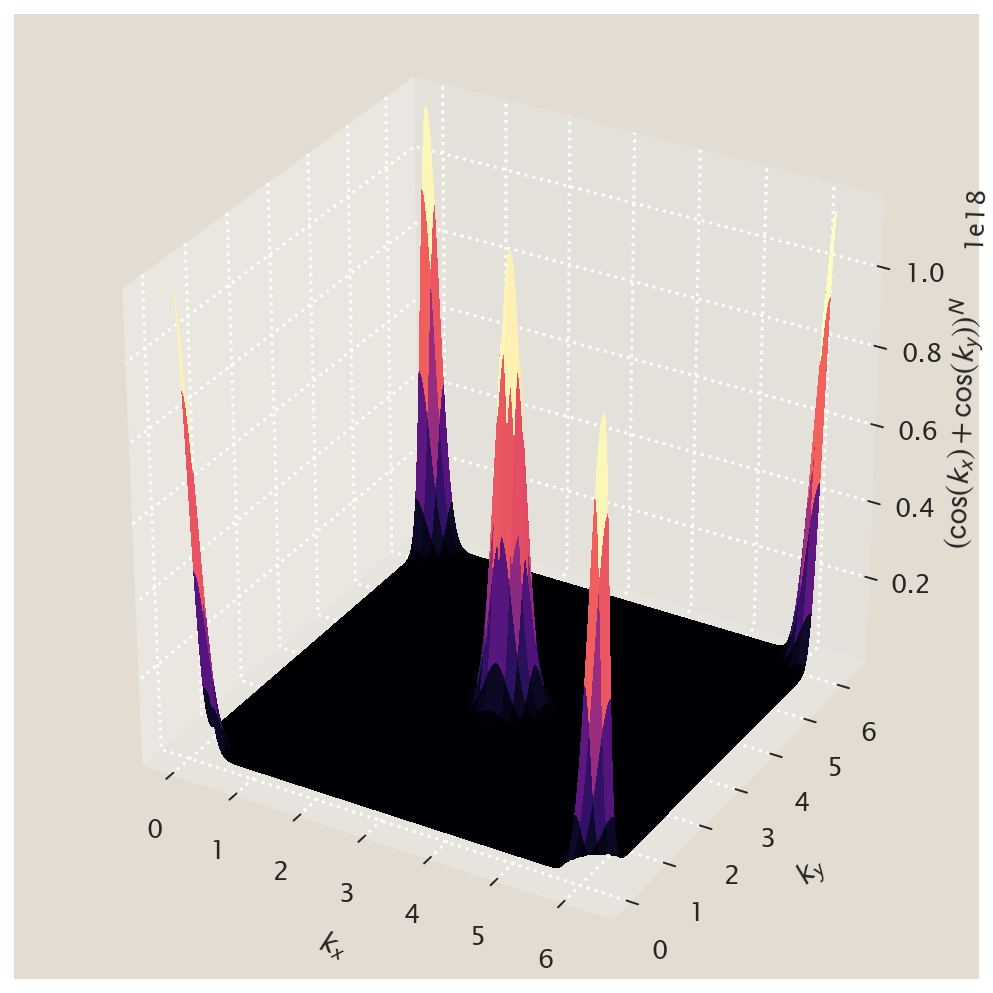

In [42]:
# Initialize 3D plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.plot_surface(xx, yy, z, cmap=cm.magma,
                       linewidth=1, antialiased=False)

# Label axis (and increase spacing between axis and label)
ax.set_xlabel(r'$k_x$', labelpad=15)
ax.set_ylabel(r'$k_y$', labelpad=15)
ax.set_zlabel(r'$(\cos(k_x) + \cos(k_y))^N$', labelpad=10)

# Set the background color to be white
# ax.patch.set_facecolor('white')

plt.tight_layout()
# Save figure
plt.savefig(figdir + 'problem_08_08_01.png', bbox_inches='tight')

## 8.10 Force-induced unfolding of multidomain proteins can be modeled using the random walk model

We can generalize the discussion of force–extension curves to the case of multidomain proteins. The data relevant to the particular case of the muscle protein titin has already been shown in Figure 8.22(C). The idea of the analysis we will bring to bear on this problem is shown in Figure 8.34, where it is seen that the overall contour length of the chain increases in a systematic and calculable way as a function of the number of domains that have unfolded. Use a model like that suggested in Figure 8.34 to compare with the data shown in Figure 8.22(C). Your fits to the data should focus only on the rising parts of the force–expansion curve. The relevant data can be found on the book’s website.

In [ ]:
Image(url='http://microsite.garlandscience.com/pboc2/resources/jpegs/figures' +
      '/ch08/ch08/figure_08_34.jpg',
     embed=True, width=500, height=500)

### Solution

To start exploring this problem let's first import the data.

In [2]:
# Read excel file
df = pd.read_excel('../data/fig8.22.xls', comment='#')
df.head()

,extension_nm,force_pN
0,57.917773,31.712290
1,58.758533,31.712290
2,59.599293,33.736339
3,60.440053,34.632855
4,61.280813,38.910293


Let's now plot the raw data.

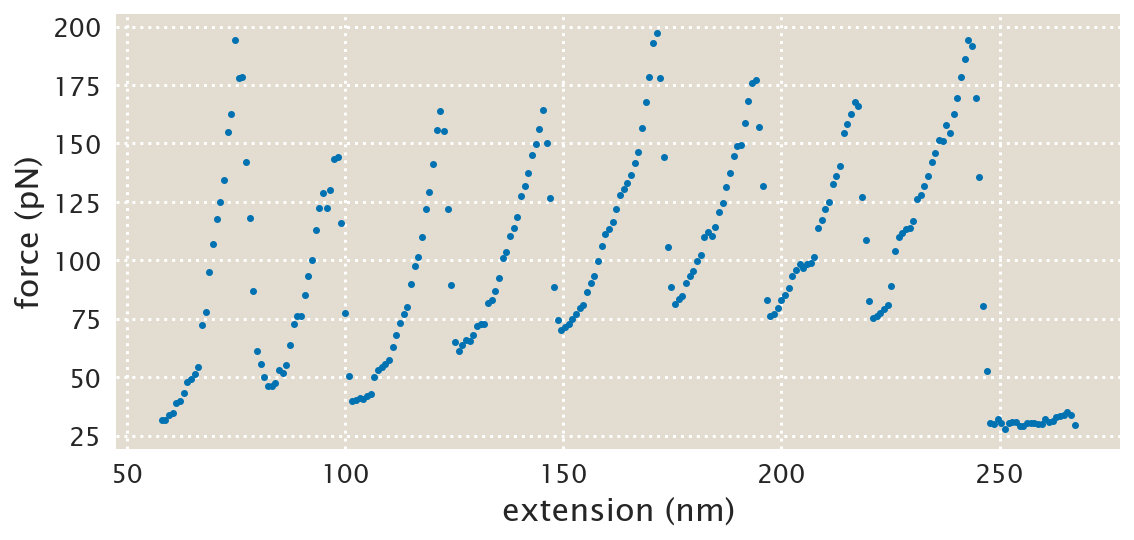

In [3]:
# Plot data using Pandas function (very convenient)
df.plot('extension_nm', 'force_pN', marker='.', lw=0, legend=False,
        figsize=(9, 4))

# Label axis
plt.xlabel('extension (nm)')
plt.ylabel('force (pN)')

In order to find whwere the peaks are we will filter the data to smooth it. For this we will apply a [Savitzky-Golay filter](https://en.wikipedia.org/wiki/Savitzky–Golay_filter) to the data.

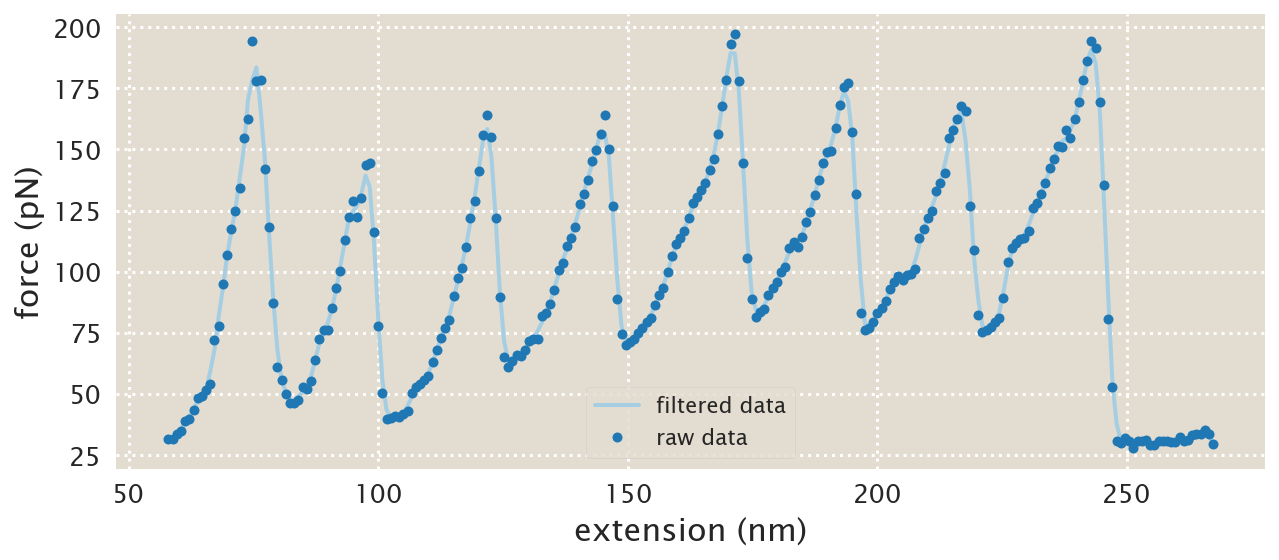

In [4]:
# Apply smoothing filter
df['force_filter'] = scipy.signal.savgol_filter(df.force_pN.values, 3, 1)

# Define colors for plot
colors = sns.color_palette('Paired', n_colors=2)

fig = plt.figure(figsize=(9, 4))
# Plot smooth data and raw data
plt.plot(df.extension_nm, df.force_filter, color=colors[0], 
         label='filtered data')
plt.plot(df.extension_nm, df.force_pN, color=colors[1], marker='.', markersize=10,
         lw=0, label='raw data')

plt.legend()
# Label axis
plt.xlabel('extension (nm)')
plt.ylabel('force (pN)')
plt.tight_layout()
plt.savefig(figdir + 'problem_08_10_01.png', bbox_inches='tight')

Having smooth the data let's find the local maxima and minima

In [5]:
# Find maxima and minima using scipy signal
max_idx = scipy.signal.argrelmax(df.force_filter.values)
min_idx = scipy.signal.argrelmin(df.force_filter.values)

# Initialize boolean array to have as an index of whether or not a point is
# an extrema
bool_idx = np.zeros(len(df), dtype=bool)

# Convert index into a Boolean statement
bool_idx[max_idx] = True
bool_idx[min_idx] = True

# Add boolean index to dataframe
df['extrema_idx'] = bool_idx

Let's see how well we did at finding the peaks

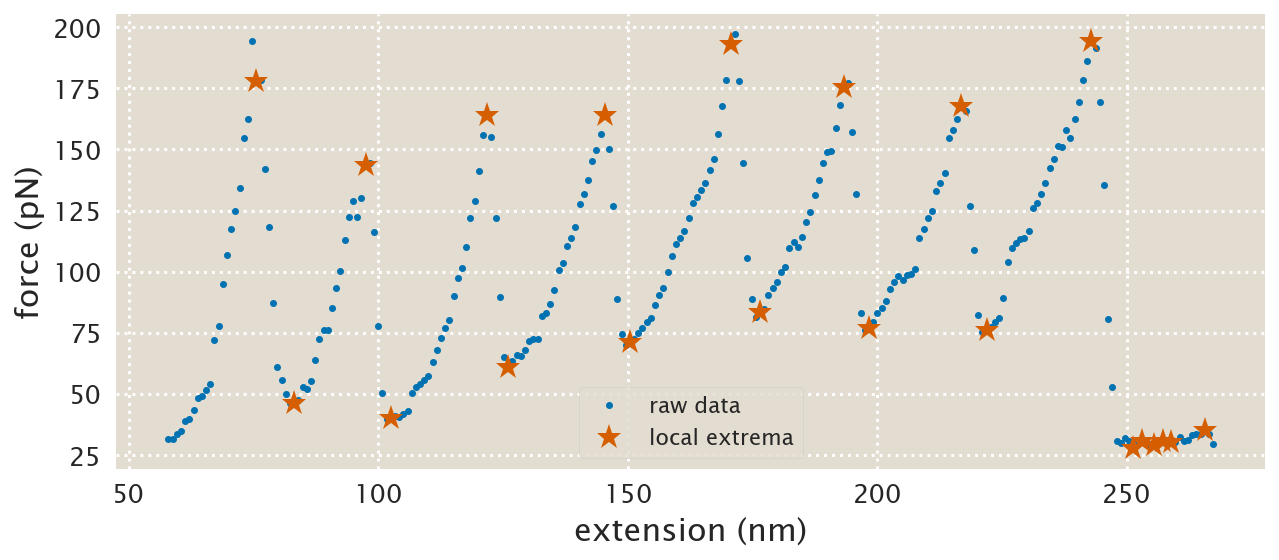

In [6]:
# Plot data using Pandas function (very convenient)
df.plot('extension_nm', 'force_pN', marker='.', lw=0, legend=False,
        figsize=(9, 4), label='raw data')

plt.plot(df[df.extrema_idx == True].extension_nm, 
         df[df.extrema_idx == True].force_pN, marker='*', markersize='13', lw=0,
         color='r', label='local extrema')

# Label axis
plt.xlabel('extension (nm)')
plt.ylabel('force (pN)')
plt.legend()
plt.tight_layout()
plt.savefig(figdir + 'problem_08_10_02.png', bbox_inches='tight')

Not too bad. Especially for the first peaks. There are a couple of errors at the end, but in general it looks good.

#### 1D polymer force-extension curve.

The model suggested in Fig. 8.34 shows a 1D polymer being pulled apart. As derived in the chapter Eq. 8.67 gives the force-extension relation for this case as
$$
{\left\langle L \right\rangle \over L_{tot}} = \tanh\left( {mga \over k_BT} \right),
$$
where $mg = f$ is a pedagogical representation of the loading force on the polymer.

If we recall that $L_{tot} \equiv Na$ we then have
$$
\left\langle L \right\rangle = Na \tanh\left( {fa \over k_BT} \right),
\label{eq_force_extension}
$$

From a bottom peak to a lower peak we know the quantity $Na$ in nm. We also know that $k_BT = 4$ pN$\cdot$nM and obviously we know $f$. So all there is to know is the Kuhn length $a$. Let's define a function to compute Eq. \ref{eq_force_extension}.

In [7]:
def force_extesion_1D(f, a, Ltot, kBT=4):
    '''
    Computes the force-extension relationship for a 1D polymer
    Parameters
    ----------
    f : array-like.
        Force applied to extend the polymer.
    a : float.
        Kuhn length of the polymer.
    L_tot : float.
        Total length of polymer
    kBT : float. Default 4 pN nM
        Thermal energy.
    '''
    return Ltot * np.tanh(f * a / kBT)

Let's now plot this for different values of *a*.

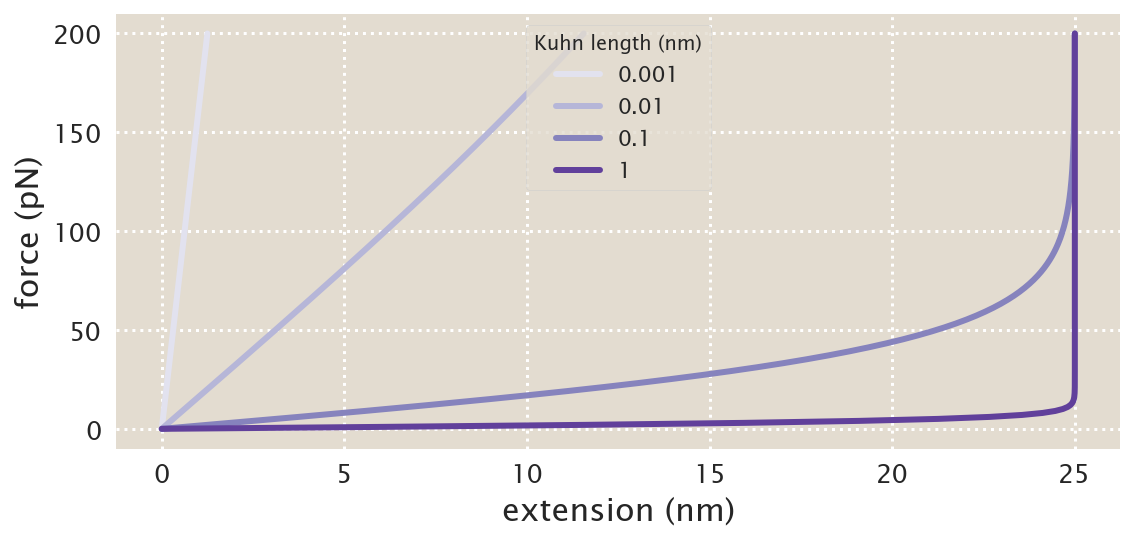

In [8]:
# Define force in pN
f = np.linspace(0, 200, 200)

# Define Ltot in nm
Ltot = 25

# Define various values of a in nm
a_array = [1E-3, 1E-2, 1E-1, 1]

# Define colors for plot
colors = sns.color_palette('Purples', n_colors=len(a_array))

# Initialize matrix to save extensions
L = np.zeros([len(a_array), len(f)])

# Initialize figure
fig = plt.figure(figsize=(9, 4))

# Loop through each of the values of the Kuhn length
for i, a in enumerate(a_array):
    # Compute extension
    L[i, :] = force_extesion_1D(f, a, Ltot)
    
    # Plot force-extension curve
    plt.plot(L[i, :], f, color=colors[i], label=a, lw=3)
    
plt.xlabel('extension (nm)')
plt.ylabel('force (pN)')
plt.legend(title='Kuhn length (nm)', loc='upper center')

From this we can see that the Kuhn length definitely affects the steepness  of the curve. Therefore we can try to find this value by fitting Eq. \ref{eq_force_extension} to each of the individual unfolding domains of the data.

Let's try this with the first section of the data

In [9]:
# Extract first section of the data
curve = df[0:np.where(df.extrema_idx)[0][0]]

# Define Ltot from the data
Ltot = curve.extension_nm.max()# - curve.extension_nm.min()

# Define a lambda function that has a fixed value of Ltot given by the data
curve_fit = lambda x, a: force_extesion_1D(x, a, Ltot=Ltot)

# Fit the parameter using scipy's curve_fit function
popt, _ = scipy.optimize.curve_fit(curve_fit, curve.force_pN.values,
                         curve.extension_nm.values,# - curve.extension_nm.min(), 
                         p0=.001)

# Print estimated Kuhn length
print('Kuhn length = {:.3f} nm'.format(popt[0]))

Kuhn length = 0.119 nm


Let's now look at the fit.

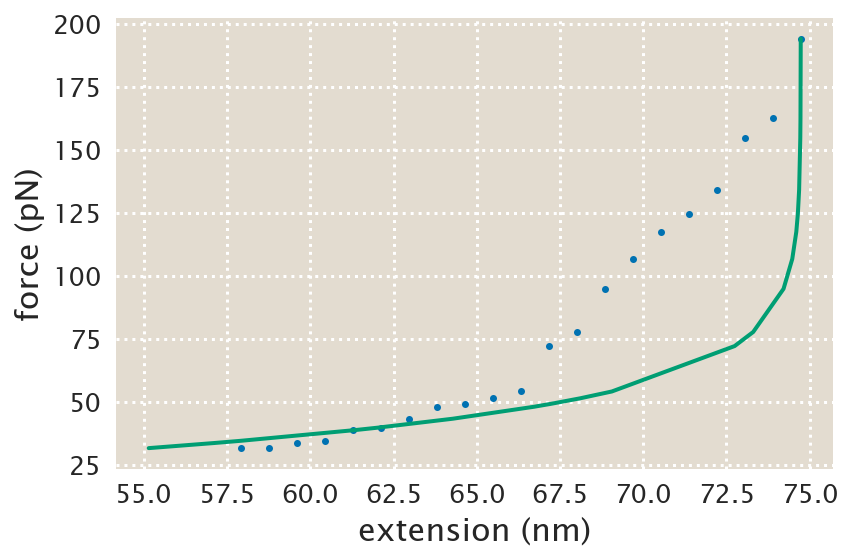

In [10]:
# Plot data
plt.plot(curve.extension_nm, curve.force_pN, marker='.', lw=0)
# Plot theoretical prediction
plt.plot(curve_fit(curve.force_pN, popt),# + curve.extension_nm.min(),
         curve.force_pN)
# Label axis
plt.xlabel('extension (nm)')
plt.ylabel('force (pN)')
plt.tight_layout()
plt.savefig(figdir + 'problem_08_10_03.png', bbox_inches='tight')

The fit is far from perfect, but remember we are using a simplifying assumption of a 1D polymer.

#### 3D polymer force-extension curve.

Let's now try fitting the model to a 3D freely-jointed chain. For this case the force-extension curve is of the form (Eq. 8.72 in the main text)
$$
\left\langle L \right\rangle = Na \left[ \coth\left( {fa \over k_BT} \right) 
- {k_BT \over fa} \right].
$$

Let's again define a function to implement this equation.

In [11]:
def force_extesion_3D(f, a, Ltot, kBT=4):
    '''
    Computes the force-extension relationship for a 1D polymer
    Parameters
    ----------
    f : array-like.
        Force applied to extend the polymer.
    a : float.
        Kuhn length of the polymer.
    L_tot : float.
        Total length of polymer
    kBT : float. Default 4 pN nM
        Thermal energy.
    '''
    return Ltot * (np.tanh(f * a / kBT)**-1 - kBT / (f * a))

And now let's fit the Kuhn length $a$ using this function as we did for the 1D case.

In [12]:
# Extract first section of the data
curve = df[0:np.where(df.extrema_idx)[0][0]]

# Define Ltot from the data
Ltot = curve.extension_nm.max()# - curve.extension_nm.min()

# Define a lambda function that has a fixed value of Ltot given by the data
curve_fit = lambda x, a: force_extesion_3D(x, a, Ltot=Ltot)

# Fit the parameter using scipy's curve_fit function
popt, _ = scipy.optimize.curve_fit(curve_fit, curve.force_pN.values,
                         curve.extension_nm.values,# - curve.extension_nm.min(), 
                         p0=.001)

# Print estimated Kuhn length
print('Kuhn length = {:.3f} nm'.format(popt[0]))

Kuhn length = 0.594 nm


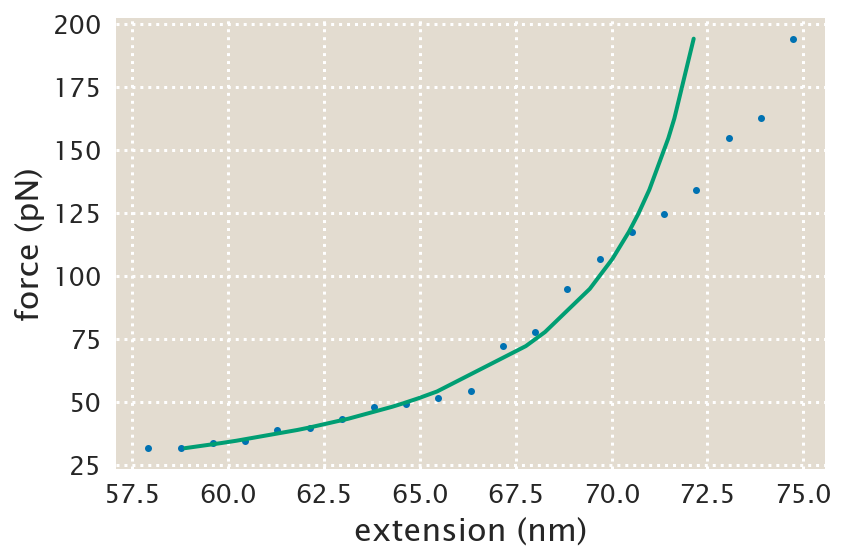

In [13]:
# Plot data
plt.plot(curve.extension_nm, curve.force_pN, marker='.', lw=0)
# Plot theoretical prediction
plt.plot(curve_fit(curve.force_pN, popt),# + curve.extension_nm.min(),
         curve.force_pN)
# Label axis
plt.xlabel('extension (nm)')
plt.ylabel('force (pN)')
plt.tight_layout()
plt.savefig(figdir + 'problem_08_10_04.png', bbox_inches='tight')

Looks slightly better this time! In the original paper they used a Worm-like-chain model to get a much better fit. That is explained in chapter 10 of the book. It might be interesting to come back to this data at that point.

## 8.11 Transition between B- and S-form DNA

DNA subjected to a stretching force exceeding 60 pN undergoes a structural transition from the usual B form to the so-called S form (“S” for stretch). Here we examine a simple model of this transition based on the freely jointed chain model of DNA and compare it with experimental data.

**(b)** Compute the average end-to-end distance for one link. The average end-to-end distance for a chain of $N$ links is $N$ times as large.

#### Solution
The average end-to-end distance for a single link $\left\langle L \right\rangle_1$ is of the form
$$
\left\langle L \right\rangle_1 = {b \sinh(\beta f b) + 
e^{-\beta \varepsilon} a \sinh(\beta f a) \over
\cosh(\beta f b) + 
e^{-\beta \varepsilon} \cosh(\beta f a)},
$$
where $b$ is the length of the B state and $a$ is the length of the S state, with $a > b$, $f$ is the force applied to the DNA strand and as usual $\beta \equiv {1 \over k_BT}$.

**(c)** Plot the average end-to-end distance normalized by $Nb$ (that is, the relative extension) as a function of force using the numbers appropriate for DNA, namely, $b = 100$ nm and, $a = 190$ nm. To estimate $\varepsilon$, take the *energy per base pair* for transforming B-DNA to S-DNA to be 5 $k_BT$ (the length of one base pair is approximately 1/3 nm for B DNA). How does your plot compare with Figure 8.35(B)?
Relevant data for this problem are provided on the book’s website. (Problem and solution suggested by Andy Spakowitz.)

#### Solution

Let's first define the parameters necessary for the computation.
Notice that the $b$ fragments are 100 nM long. Since each basepair is 1/3 of a nanometer, that implies that there are 300 bp in a fragment. Since $\varepsilon$ is the contribution per basepair we need to multiply this number by 300 then.

In [3]:
# Define model parameters
a = 190 # nm
b = 100 # nm
epsilon = 5 * 300 # kBT

kBT = 4.1 # pN nm

# Define array of forces
f_array = np.linspace(1, 80) # pN

Now let's compute the extension as a function of the force. Since we are computing the normalized extension we do not need to specify $N$; we just need to divide the extension by $b$ itself since the length of a polymer is $N$ times the length of a monomer.

**Note**: We will use the package `mpmath` to compute this beacuse of the incredibly large numbers that come out of `sinh` and `cosh`.

In [4]:
# Initialize array to save values
L_avg = np.empty_like(f_array)

# Loop through each value. We do this because we have to work with mpmath
# due to the numerical instability of this function (very large numbers)
for i, f in enumerate(f_array):
    L_avg[i] = (b * mpmath.sinh(f * b / kBT) +
                mpmath.exp(-epsilon) * a * mpmath.sinh(f * a / kBT)) / \
                (mpmath.cosh(f * b / kBT) +
                 mpmath.exp(-epsilon) * mpmath.cosh(f * a / kBT))

Now let's plot the result.

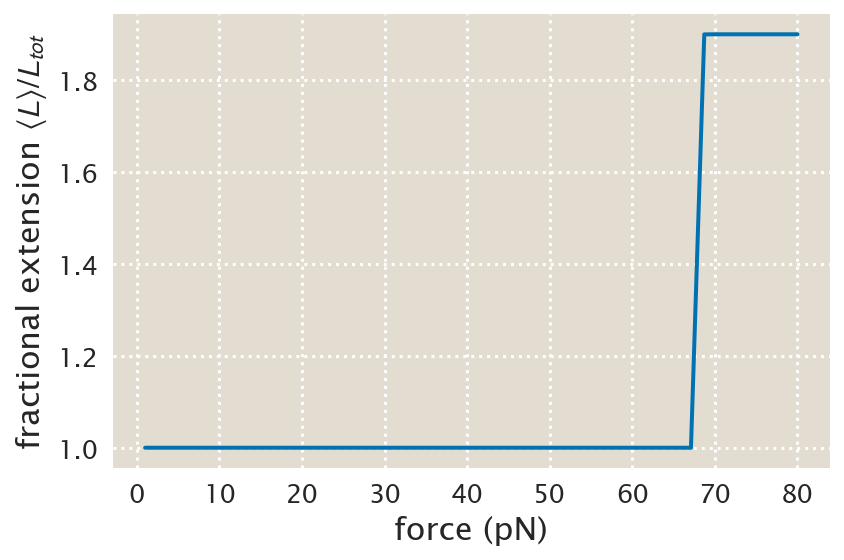

In [5]:
plt.plot(f_array, L_avg / b)

# Label axis
plt.xlabel('force (pN)')
plt.ylabel(r'fractional extension $\left\langle L \right\rangle / L_{tot}$')
plt.tight_layout()
plt.savefig(figdir + 'problem_08_11_01.png', bbox_inches='tight')

In [ ]:
Image(url='http://microsite.garlandscience.com/pboc2/resources/jpegs/figures' +
      '/ch08/ch08/figure_08_35.jpg',
     embed=True, width=500, height=500)